# Happywhale - CS795 Project 1
***
Old Dominion University

2/26/2022
#### Authors: Raphael J. Sandor, Xiangrui Xu


# Imports

In [1]:
import efficientnet.tfkeras as efn
import glob
import json
import keras
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import pickle
import pathlib
import seaborn as sns
import warnings
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as tfhub
import re
from scipy import stats
from scipy.stats import norm
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from PIL import Image
from pathlib import Path
from datetime import datetime
from keras.optimizers import adam_v2
from tensorflow.keras import backend as K
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

# Global Data

In [2]:
train_df = pd.read_csv('train.csv')

'''
    Use sample submission to gather which 
    images need predictions made 
'''
test_df = pd.read_csv('sample_submission.csv')

total_image_df =  pd.concat([train_df['image'], test_df['image']])
TRAIN_IMAGES_DIR = Path("./train_images")
TEST_IMAGES_DIR = Path("./test_images")
train_images = list(TRAIN_IMAGES_DIR.glob('./*'))

# Exploritory Data Analysis

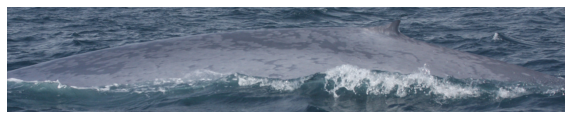

In [3]:
img = PIL.Image.open(str(train_images[1000]))
plt.figure(figsize = (10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
trainImgCnt = len(list(TRAIN_IMAGES_DIR.glob('*.jpg')))
testImgCnt = len(list(TEST_IMAGES_DIR.glob('*.jpg')))

In [5]:
print("Train image count: " + str(trainImgCnt))
print("Test image count: " + str(testImgCnt))

Train image count: 51033
Test image count: 27956


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51033 entries, 0 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          51033 non-null  object
 1   species        51033 non-null  object
 2   individual_id  51033 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [7]:
# Data in train
train_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


## Unique Species 

In [8]:
species = train_df['species']

In [9]:
train_df.describe()

,image,species,individual_id
count,51033,51033,51033
unique,51033,30,15587
top,00021adfb725ed.jpg,bottlenose_dolphin,37c7aba965a5
freq,1,9664,400


In [10]:
unique_species = pd.unique(species) # returns numpy.ndarray 
print("Unique Species")
print("-------------------")
print(*unique_species, sep='\n')

Unique Species
-------------------
melon_headed_whale
humpback_whale
false_killer_whale
bottlenose_dolphin
beluga
minke_whale
fin_whale
blue_whale
gray_whale
southern_right_whale
common_dolphin
kiler_whale
pilot_whale
dusky_dolphin
killer_whale
long_finned_pilot_whale
sei_whale
spinner_dolphin
bottlenose_dolpin
cuviers_beaked_whale
spotted_dolphin
globis
brydes_whale
commersons_dolphin
white_sided_dolphin
short_finned_pilot_whale
rough_toothed_dolphin
pantropic_spotted_dolphin
pygmy_killer_whale
frasiers_dolphin


# Whales and Dolphins

In [11]:
# Note that the dataset includes some typo mistakes mistakes.
train_df['species'].replace('bottlenose_dolpin', 'bottlenose_dolphin', inplace=True)
train_df['species'].replace('kiler_whale', 'killer_whale', inplace=True)
train_df['species'][(train_df['species'] =="pilot_whale") | (train_df['species'] =="globis" )]='short_finned_pilot_whale'

whales = ['humpback_whale','beluga','minke_whale', 'fin_whale', 'blue_whale', 'gray_whale',
          'southern_right_whale','sei_whale', 'cuviers_beaked_whale', 'brydes_whale']

dolphins = ['melon_headed_whale','false_killer_whale', 'bottlenose_dolphin', 'common_dolphin', 
            'dusky_dolphin', 'killer_whale', 'long_finned_pilot_whale', 'spinner_dolphin', 
            'spotted_dolphin','commersons_dolphin', 'white_sided_dolphin', 'short_finned_pilot_whale',
            'rough_toothed_dolphin', 'pantropic_spotted_dolphin', 'frasiers_dolphin', 'pygmy_killer_whale']

In [12]:
whale_df = train_df[train_df['species'].str.contains('|'.join(whales))]
dolphin_df = train_df[train_df['species'].str.contains('|'.join(dolphins))]
print("Total species after :",len(train_df.species.unique()))

Total species after : 26


In [13]:
print(whale_df.head())
print("---------------------------------------------")
print(dolphin_df.head())

                image         species individual_id
1  000562241d384d.jpg  humpback_whale  1a71fbb72250
4  00087baf5cef7a.jpg  humpback_whale  8e5253662392
6  000be9acf46619.jpg          beluga  afb9b3978217
7  000bef247c7a42.jpg  humpback_whale  444d8894ccc8
8  000c3d63069748.jpg          beluga  df94b15285b9
---------------------------------------------
                image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
5  000a8f2d5c316a.jpg  bottlenose_dolphin  b9907151f66e
9  000c476c11bad5.jpg  bottlenose_dolphin  b11b2404c7e3


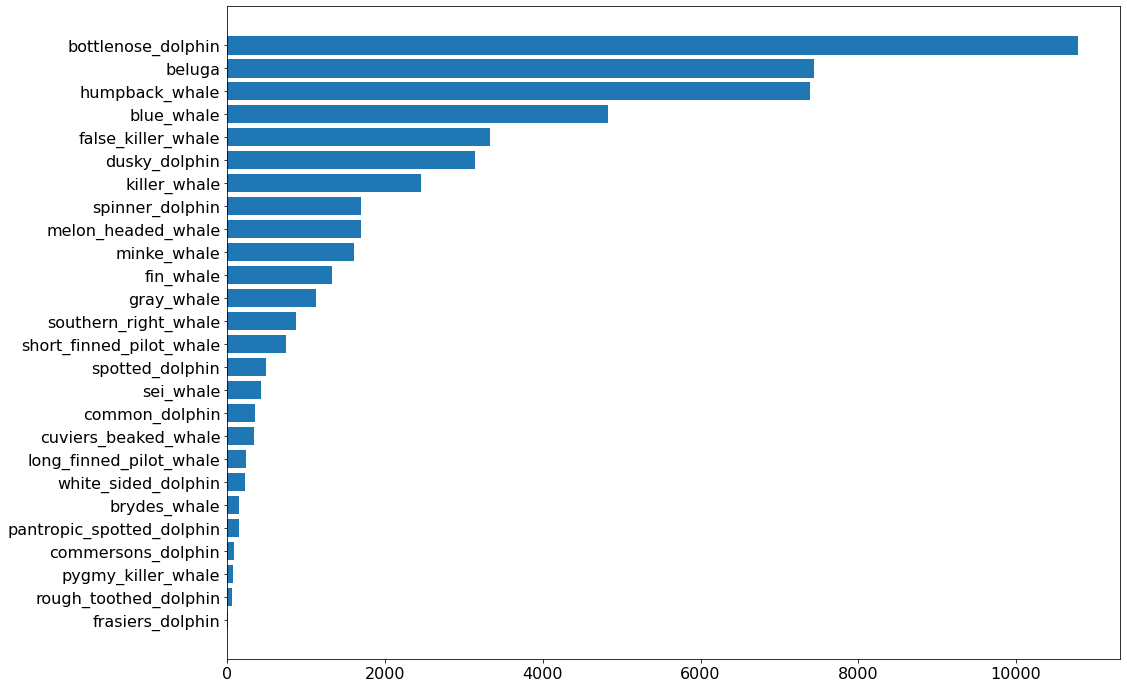

In [14]:
## lets check speiceis in visually
# Nikhil Jothi Prakash 
# Works cited: https://www.kaggle.com/nikhiljothiprakash/happy-whale-and-dolphin
plt.figure(figsize=(16, 12))
plt.rcParams["font.size"] = 16
plt.barh(train_df["species"].value_counts().sort_values(ascending=True).index,train_df["species"].value_counts().sort_values(ascending=True),tick_label = train_df["species"].value_counts().sort_values(ascending=True).index)
plt.show()

In [15]:
print("Species of whales: " + str(len(whales)))
print("Species of dolphins: " + str(len(dolphins)))

Species of whales: 10
Species of dolphins: 16


In [16]:
print("Number of whales: " + str(whale_df.shape[0]))
print("Number of dolphins: " + str(dolphin_df.shape[0]))

Number of whales: 25509
Number of dolphins: 25524


In [17]:
# now lets classify on whales.
train_df['isWhale'] = train_df.species.isin(whale_df.species).astype(int)
train_data = []

In [18]:
train_df.describe()

,isWhale
count,51033.000000
mean,0.499853
std,0.500005
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [19]:
# Borrowed from 
# https://www.kaggle.com/samir95/species-classification
_, dev, _ , _ = train_test_split(train_df, train_df['isWhale'], test_size=0.1)

dev.shape

(5104, 4)

# CNN Dataset
<ol>
  <li>Load the data.</li>
  <li>Resize images to be normalized</li>
</ol>
<i> If I had more time and knowledge I would use the TFRecords from the next step </i>

In [20]:
import fastai
from fastai.vision.all import *
from fastai.basics import *
from fastai.data.all import *

from fastai.vision.core import *
import fastbook
fastbook.setup_book() 
pd.options.mode.chained_assignment = None  # default='warn'

dev['imagePath'] = dev['image'].apply(lambda f: TRAIN_IMAGES_DIR/f)
train_df['imagePath'] = train_df['image'].apply(lambda f: TRAIN_IMAGES_DIR/f)

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_x=ColReader('imagePath'),
                   get_y=lambda r: r['isWhale'],
                   splitter=RandomSplitter(seed=42),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224))
#dblock.summary(dev)
dsets = dblock.datasets(dev)
dls = dblock.dataloaders(dev)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


# TFRecords For Faster Performance 
##### Creating TFRecords will provide better performance than manual image manipulations according to Keras.
https://keras.io/examples/keras_recipes/creating_tfrecords/

<i> We'll use this when we do individual predicitions <i>

## Setup Data

In [21]:
# Works cited:
# https://www.kaggle.com/nikhiljothiprakash/happy-whale-and-dolphin/notebook
concat_df = pd.concat([train_df['image'], test_df['image']])

### Dictionaries

In [22]:
## lets create dict for species
spid_dict = dict((a,b) for b,a in enumerate(train_df.species.unique()))
spid_dict_inverse={(c,d) for d,c in spid_dict.items()}

In [23]:
image_name_to_image_id = dict((image_name, index) for index, image_name in enumerate(concat_df.unique()))

In [24]:
img_dict = dict((image,index) for index,image in enumerate(concat_df.unique()))
img_dict_inverse = {ind:img for img,ind in img_dict.items()}

In [25]:
## lets create dict for individual id 
id_dict = dict((a,b) for b,a in enumerate(train_df.individual_id.unique()))
id_dict_inverse={(c,d) for d,c in id_dict.items()}

In [26]:
train_df["label"]=[id_dict[i] for i in train_df.individual_id]
train_df["image_id"]=[img_dict[i] for i in train_df['image']]
train_df.head(20)

,image,species,individual_id,isWhale,imagePath,label,image_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,0,train_images\00021adfb725ed.jpg,0,0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,1,train_images\000562241d384d.jpg,1,1
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,0,train_images\0007c33415ce37.jpg,2,2
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,0,train_images\0007d9bca26a99.jpg,3,3
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,1,train_images\00087baf5cef7a.jpg,4,4
5,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e,0,train_images\000a8f2d5c316a.jpg,5,5
6,000be9acf46619.jpg,beluga,afb9b3978217,1,train_images\000be9acf46619.jpg,6,6
7,000bef247c7a42.jpg,humpback_whale,444d8894ccc8,1,train_images\000bef247c7a42.jpg,7,7
8,000c3d63069748.jpg,beluga,df94b15285b9,1,train_images\000c3d63069748.jpg,8,8
9,000c476c11bad5.jpg,bottlenose_dolphin,b11b2404c7e3,0,train_images\000c476c11bad5.jpg,9,9


### Helper Functions
Borrowed from Keras:https://keras.io/examples/keras_recipes/creating_tfrecords/

In [27]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


## Create TFRecords
Faster image manipulation in the future.

In [28]:
# Borrowed example of making records from 
# Gaurav Chopra
# https://www.kaggle.com/gauravchopracg/understanding-tfrecord-format
# Create a function to apply entire process to each element of dataset.
# process the two images into 'tf.Example' messages.
def create_example(image_id, image, label):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
  feature = {
    "image_id": int64_feature(image_id),
    "image": image_feature(image),
    "label": int64_feature(label)
  }  
  # Create a Features message using tf.train.Example.
  return tf.train.Example(features=tf.train.Features(feature=feature))


def  write_records():
  #Write the `tf.Example` observations to the file.
  with tf.io.TFRecordWriter(train_records) as writer:
    for i, row in new.iterrows():
      image = tf.io.decode_jpeg(tf.io.read_file(str(row['imagePath'])))
    
      # storing all the features in the tf.Example message.
      tf_example = create_example(row['image_id'], image, row['label'])
      # write the example messages to a file named images.tfrecords
      writer.write(tf_example.SerializeToString())

In [ ]:
# define a filename to store preprocessed image data:
train_records = 'trainImages.tfrecords'
test_records = 'testImages.tfrecords'
new = train_df[['image_id','imagePath', 'label']].copy()

if not os.path.exists("trainImages.tfrecords"):
  write_records()
    

# Start CNN Learning

SuggestedLRs(valley=0.0005754399462603033)

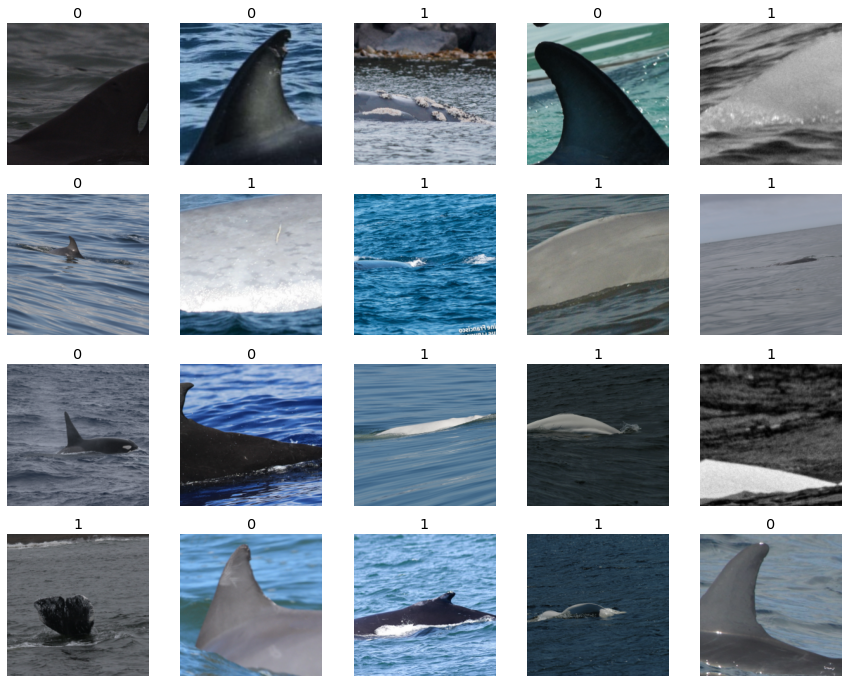

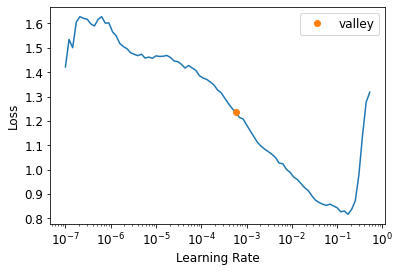

In [30]:
dls.show_batch(max_n=20)
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.lr_find()

# Fine Tune and Improve

In [38]:
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.467438,0.223824,0.934314,0.065686,13:48


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.222052,0.114837,0.966667,0.033333,14:36
1,0.133857,0.085002,0.968627,0.031373,14:33


In [49]:
learn.save('./models')
learn.freeze()
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.095176,0.131136,0.954902,0.045098,12:39
1,0.092067,0.104745,0.970588,0.029412,12:36
2,0.078366,0.079567,0.975490,0.024510,12:41


In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=slice(1e-6, 1e-4))


## To do predictions on test set using trained model 


In [ ]:
test_images = list(TEST_IMAGES_DIR.glob('*.jpg'))
result = []
for img in test_images:
    img_test = PILImage.create(img)
    print("image No. ",img, " prediction result label(isWhale): ", learn.predict(img_test)[0])
    

# Classification based on Individual 
#### using research by Andre C. Ferreira as a starting point on this venture
##### https://github.com/AndreCFerreira/Bird_individualID/blob/master/Train_CNN/TRAIN_CNN.ipynb

Lets explore how many individuals we are working with in this

In [ ]:
from sklearn import model_selection

In [ ]:
def create_folds(data,target,num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data[target], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

In [ ]:
# image to array
def decode_image(image_raw):
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [ ]:
def read_tfrecord(raw_image_dataset):
    feature_description = {
        "image_id": tf.io.FixedLenFeature([], tf.int64),
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }

    parsed_image_dataset = tf.io.parse_single_example(raw_image_dataset, feature_description)
    image_id = tf.cast(parsed_image_dataset['image_id'], tf.int32)
    image = decode_image(parsed_image_dataset['image_raw'])
    label = tf.cast(parsed_image_dataset['label'], tf.int32)
    
    return image_id, image, label

In [ ]:
save_dir = '.'
EXPERIMENT = 0
run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)

In [ ]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()


class config:
    
    
    SEED = 42
    FOLD_TO_RUN = 0
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 512
    N_CLASSES = 15587
    
    ### Model
    model_type = 'effnetv1'  
    EFF_NET = 5
    EFF_NETV2 = 's-21k-ft1k'
    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 20
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 50
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)



In [ ]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

In [ ]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path('happywhale-tfrecords-v1')
    
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))
